# Original notebook
- https://github.com/aws-samples/amazon-sagemaker-script-mode/blob/master/tf-sentiment-script-mode/sentiment-analysis.ipynb

## Modified Points:
- This notebook is tested in SageMaker Studio with kernel Python3 (Tensorflow2 GPU Optimized)
- Use training script sentiment-gs.py that is tested on scratch_sentiment.ipynb
- Exclude local mode training using local docker becasue of not working local_mode.sh in SageMaker Studio
- Add to create endpoint and inference
- Exclude batch transform because of having an error
  --> Enable the code block after adding "! pip install -U --user sagemaker".
      After that, the batch transform is working
      (Ref: https://github.com/aws-samples/amazon-sagemaker-script-mode/issues/8)

#  Sentiment Analysis with TensorFlow 2

Amazon SageMaker provides both built-in algorithms and an easy path to train your own custom models.  Although the built-in algorithms cover many domains (computer vision, natural language processing etc.) and are easy to use (just provide your data), sometimes training a custom model is the preferred approach.  This notebook will focus on training a custom model using TensorFlow 2.  

Sentiment analysis is a very common text analytics task that involves determining whether a text sample is positive or negative about its subject.  There are several different algorithms for performing this task, including statistical algorithms and deep learning algorithms.  With respect to deep learning, a 1D Convolutional Neural Net (CNN) is sometimes used for this purpose.  In this notebook we'll use a CNN built with TensorFlow 2 to perform sentiment analysis in Amazon SageMaker on the IMDB dataset, which consists of movie reviews labeled as having positive or negative sentiment. Three aspects of Amazon SageMaker will be demonstrated:

- How to use a SageMaker prebuilt TensorFlow 2 container with a custom model training script similar to one you would use outside SageMaker. This feature is known as Script Mode.  
- Local Mode training:  this allows you to prototype and test your code on a low-cost notebook instance before creating a full scale training job on more powerful and expensive instances.
- Hosted training: for full scale training on a complete dataset.  
- Distributed training:  using a single, multi-GPU instance to speed up training.  
- Batch Transform for offline, asynchronous predictions on large batches of data. 

#  Prepare the dataset

We'll begin by loading the reviews dataset, and padding the reviews so all reviews have the same length.  Each review is represented as an array of numbers, where each number represents an indexed word.  We'll also pad shorter reviews to match a maximum specified length.

### After adding this code, the following batch transform is working

In [16]:
! pip install -U --user sagemaker

     |################################| 290 kB 14.3 MB/s eta 0:00:01
     |################################| 128 kB 43.7 MB/s eta 0:00:01
     |################################| 6.2 MB 43.5 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.60.2-py2.py3-none-any.whl size=392337 sha256=c4283103a11ab12d6e5f79d8d4c85b61a9457c6543ddaf40a8123c3a74bd08b3
  Stored in directory: /root/.cache/pip/wheels/af/35/94/2bb2d2638a2be23d1a1ab9bff1040f96dc76ef0086dd52da77
Successfully built sagemaker
ERROR: awscli 1.18.22 has requirement botocore==1.15.22, but you'll have botocore 1.16.19 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [17]:
import os
# os.chdir('/home/sagemaker-user/tf-sentiment-script-mode')
os.chdir('/root/tensorflow-sagemaker-examples/tf-sentiment-script-mode')
os.getcwd()

'/root/tensorflow-sagemaker-examples/tf-sentiment-script-mode'

In [18]:
%matplotlib inline

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import numpy as np
import os

from tensorflow.keras.preprocessing import sequence
from tensorflow.python.keras.datasets import imdb

max_features = 20000
maxlen = 400

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

25000 train sequences
25000 test sequences
x_train shape: (25000, 400)
x_test shape: (25000, 400)


Training data for both Local Mode training and hosted Training must be saved as files.  Accordingly, we'll save the padded data to files, locally for now, and later to Amazon S3.

In [19]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [20]:
data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)

train_dir = os.path.join(os.getcwd(), 'data/train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(os.getcwd(), 'data/test')
os.makedirs(test_dir, exist_ok=True)

csv_test_dir = os.path.join(os.getcwd(), 'data/csv-test')
os.makedirs(csv_test_dir, exist_ok=True)

np.save(os.path.join(train_dir, 'x_train.npy'), x_train)
np.save(os.path.join(train_dir, 'y_train.npy'), y_train)
np.save(os.path.join(test_dir, 'x_test.npy'), x_test)
np.save(os.path.join(test_dir, 'y_test.npy'), y_test)
np.savetxt(os.path.join(csv_test_dir, 'csv-test.csv'), np.array(x_test[:100], dtype=np.int32), fmt='%d', delimiter=",")

# Local Mode Training & Git Integration

Amazon SageMaker’s Local Mode training feature is a convenient way to make sure your code is working as expected before moving on to full scale, hosted training. With Local Mode, you can run quick tests with just a sample of training data, and/or a small number of epochs (passes over the full training set), while avoiding the time and expense of attempting full scale hosted training using possibly buggy code.  

### Prepare for Local Mode

To train in Local Mode, it is necessary to have docker-compose or nvidia-docker-compose (for GPU) installed. Running the following script will install docker-compose or nvidia-docker-compose and configure the notebook environment for you.

In [21]:
!wget -q https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-script-mode/master/local_mode_setup.sh
!wget -q https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-script-mode/master/daemon.json    
! /bin/bash ./local_mode_setup.sh

./local_mode_setup.sh: line 7: rpm: command not found
./local_mode_setup.sh: line 10: yum: command not found
./local_mode_setup.sh: line 12: [: -eq: unary operator expected
./local_mode_setup.sh: line 20: sudo: command not found
./local_mode_setup.sh: line 21: sudo: command not found
./local_mode_setup.sh: line 23: sudo: command not found
./local_mode_setup.sh: line 25: sudo: command not found
(23) Failed writing body
./local_mode_setup.sh: line 26: sudo: command not found
./local_mode_setup.sh: line 27: sudo: command not found
./local_mode_setup.sh: line 28: sudo: command not found
installed nvidia-docker2
./local_mode_setup.sh: line 45: docker: command not found
./local_mode_setup.sh: line 47: docker: command not found
./local_mode_setup.sh: line 51: sudo: command not found
./local_mode_setup.sh: line 54: docker: command not found
./local_mode_setup.sh: line 55: ip: command not found
./local_mode_setup.sh: line 56: ip: command not found
./local_mode_setup.sh: line 59: sudo: command n

### Git Configuration

Now we need a training script that can be used to train the model in Amazon SageMaker.  In this example, we'll use Git integration. That is, you can specify a training script that is stored in a GitHub, AWS CodeCommit or another Git repository as the entry point so that you don't have to download the scripts locally. If you do so, any source directory and dependencies should be in the same repo if they are needed.

To use Git integration, pass a dict `git_config` as a parameter when you create an Amazon SageMaker Estimator object. In the `git_config` parameter, you specify the fields `repo`, `branch` and `commit` to locate the specific repo you want to use. If you do not specify `commit` in `git_config`, the latest commit of the specified repo and branch will be used by default.  Also, if authentication is required to access the repo, you can specify fields `2FA_enabled`, `username`, `password` and `token` accordingly.

The script that we will use in this example is stored a public GitHub repo so we don't need authentication to access it. Let's specify the `git_config` argument here:

In [22]:
# git_config = {'repo': 'https://github.com/aws-samples/amazon-sagemaker-script-mode', 
#               'branch': 'master'}

### Local Mode Estimator setup

The next step is to set up a TensorFlow Estimator for Local Mode training. The Estimator will be used to configure and start a training job.  A key parameters for the Estimator is the `train_instance_type`, which is the kind of hardware on which training will run. In the case of Local Mode, we simply set this parameter to `local_gpu` to invoke Local Mode training on the GPU, or to `local` if the instance has a CPU. Other parameters of note are the algorithm’s hyperparameters, which are passed in as a dictionary, and a Boolean parameter indicating that we are using Script Mode.

In [23]:
# import sagemaker
# from sagemaker.tensorflow import TensorFlow

# model_dir = '/opt/ml/model'
# train_instance_type = 'local_gpu'
# hyperparameters = {'epochs': 1, 'batch_size': 64, 'learning_rate': 0.01}
# local_estimator = TensorFlow(
#     git_config = git_config,
#     source_dir = 'tf-sentiment-script-mode',
#     entry_point = 'sentiment.py',    
#     model_dir = model_dir,
#     train_instance_type = train_instance_type,
#     train_instance_count = 1,
#     hyperparameters = hyperparameters,
#     role = sagemaker.get_execution_role(),
#     base_job_name = 'tf-sentiment',
#     framework_version = '2.1',
#     py_version = 'py3',
#     script_mode = True
#     )

Now we'll briefly train the model in Local Mode.  Since this is just to make sure the code is working, we'll train for only one epoch.  On a notebook instance using a general purpose CPU-based instance type such as m5.xlarge, this one epoch will take about 3 or 4 minutes.  As you'll see from the logs below the cell when training is complete, even when trained for only one epoch, the accuracy of the model on training data is around 80%.  

In [24]:
# inputs = {'train': f'file://{train_dir}',
#           'test': f'file://{test_dir}'}

# local_estimator.fit(inputs)

#  Hosted Training

After we've confirmed our code is working using Local Mode training, we can move on to use SageMaker's hosted training, which typically uses more powerful compute resources separate from your less powerful, lower cost notebook instance.  Hosted training spins up one or more instances (i.e. a cluster) for training, and then tears the cluster down when training is complete. In general, hosted training is preferred for doing actual large-scale training on more powerful instances, especially for distributed training on a single instance with multiple GPUs or multiple instances each having multiple GPUs. 

### Upload data to S3

Before starting hosted training, the data must be present in storage that can be accessed by SageMaker. The storage options are:  Amazon S3 (object storage service), Amazon EFS (elastic NFS file system service), and Amazon FSx for Lustre (high-performance file system service). For this example, we'll upload the data to S3.  

In [25]:
import sagemaker

s3_prefix = 'tf-keras-sentiment'

traindata_s3_prefix = '{}/data/train'.format(s3_prefix)
testdata_s3_prefix = '{}/data/test'.format(s3_prefix)

train_s3 = sagemaker.Session().upload_data(path='./data/train/', key_prefix=traindata_s3_prefix)
test_s3 = sagemaker.Session().upload_data(path='./data/test/', key_prefix=testdata_s3_prefix)

inputs = {'train':train_s3, 'test': test_s3}
print(inputs)

{'train': 's3://sagemaker-us-east-1-057716757052/tf-keras-sentiment/data/train', 'test': 's3://sagemaker-us-east-1-057716757052/tf-keras-sentiment/data/test'}


### Hosted training Estimator setup

With the training data now in S3, we're ready to set up an Estimator object for hosted training. It is similar to the Local Mode Estimator, except the `train_instance_type` has been set to a ML instance type instead of a local type for Local Mode. Additionally, we've increased the number of epochs for actual training, as opposed to just testing the code in Local Mode.

In [26]:
from sagemaker.tensorflow import TensorFlow

model_dir = '/opt/ml/model'
train_instance_type = 'ml.p3.8xlarge'
hyperparameters = {'epochs': 10, 'batch_size': 256, 'learning_rate': 0.01}

estimator = TensorFlow(
#                       git_config=git_config,
#                       source_dir='tf-sentiment-script-mode',
                       entry_point='sentiment_gs.py',
                       model_dir=model_dir,
                       train_instance_type=train_instance_type,
                       train_instance_count=1,
                       hyperparameters=hyperparameters,
                       role=sagemaker.get_execution_role(),
                       base_job_name='tf-sentiment',
                       framework_version='2.1',
                       py_version='py3',
                       script_mode=True)

### Distributed training on a single multi-GPU instance

The instance type selected above, p3.8xlarge, contains four GPUs based on NVIDIA's V100 Tensor Core architecture.  This presents an opportunity to do distributed training within a single multi-GPU instance, utilizing all four GPUs to reduce total training time compared to using a single GPU.  Although using multiple instances also is a possibility, using a single multi-GPU instance may be more performant because it avoids extra network traffic necessary to coordinate multiple instances.  For larger datasets and more complex models, using multiple instances may be a necessity, however, that is not the case here.

To utilize all four GPUs on the instance, you don't need to do anything special in Amazon SageMaker:  TensorFlow 2 itself will handle the details under the hood.  TensorFlow 2 includes several native distribution strategies, including MirroredStrategy, which is well-suited for training a model using multiple GPUs on a single instance.  To enable MirroredStrategy, simply add the following lines of code in your training script before you define and compile the model:

```python
def get_model(learning_rate):

    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        embedding_layer = tf.keras.layers.Embedding(max_features,
                                                    embedding_dims,
                                                    input_length=maxlen)
        ....
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    
    return model
```

Additionally, the batch size was increased in the Estimator hyperparameters to account for the fact that batches are divided among multiple GPUs.  If you are interested in reviewing the rest of the training code, it is at the GitHub repository referenced above in the `git_config` variable.  

### Start the hosted training job

With the change in training instance type and increase in epochs, we simply call `fit` to start the actual hosted training.  The training job should take around 5 minutes, including the time needed to spin up the training instance.  At the end of hosted training, you'll see from the logs below the cell that accuracy on the training set has greatly increased, and accuracy on the validation set is approaching 90%.  

In [27]:
os.getcwd()

'/root/tensorflow-sagemaker-examples/tf-sentiment-script-mode'

In [28]:
estimator.fit(inputs)

2020-05-31 00:50:50 Starting - Starting the training job...
2020-05-31 00:50:52 Starting - Launching requested ML instances.........
2020-05-31 00:52:32 Starting - Preparing the instances for training.........
2020-05-31 00:54:15 Downloading - Downloading input data
2020-05-31 00:54:15 Training - Downloading the training image.........
2020-05-31 00:55:33 Training - Training image download completed. Training in progress.2020-05-31 00:55:37,995 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-05-31 00:55:38,429 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch_size": 256,
        "mo

Although the training accuracy has improved, the validation accuracy plateaued, so the model might be overfitting now:  it could be less able to generalize to data it has not yet seen.  This is the case even though we are employing dropout as a regularization technique to reduce the possibility of overfitting.  (See the training script at the GitHub repository referenced above.)  For a production model, further experimentation would be necessary.

TensorFlow 2's tf.keras API provides a convenient way to capture the history of model training.  When the model was saved after training, the history was saved alongside it.  To retrieve the history, we first download the trained model from the S3 bucket where SageMaker stored it.  Models trained by SageMaker are always accessible in this way to be run anywhere.  Next, we can unzip it to gain access to the history data structure, and then simply load the history as JSON:

In [29]:
import json

!aws s3 cp {estimator.model_data} ./model/model.tar.gz
!tar -xzf ./model/model.tar.gz -C ./model

with open('./model/history.p', "r") as f:
    history = json.load(f)

download: s3://sagemaker-us-east-1-057716757052/tf-sentiment-2020-05-31-00-50-49-950/output/model.tar.gz to model/model.tar.gz


Now we can plot the training curves based on the history, with separate graphs for model accuracy and model loss.  We can see that training converged relatively smoothly to higher model accuracy and correspondingly lower model loss.

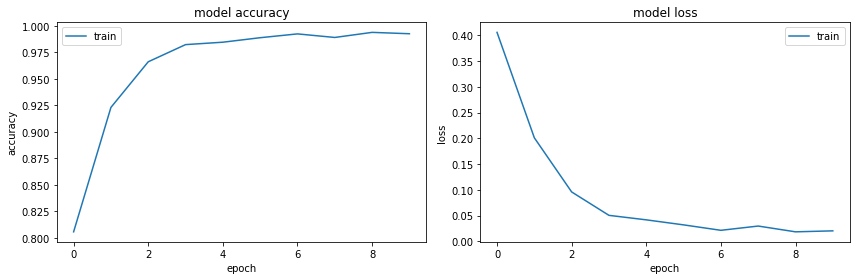

In [30]:
import matplotlib.pyplot as plt

def plot_training_curves(history): 
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    ax = axes[0]
    ax.plot(history['accuracy'], label='train')
    ax.set(title='model accuracy', ylabel='accuracy', xlabel='epoch')
    ax.legend()
    ax = axes[1]
    ax.plot(history['loss'], label='train')
    ax.set(title='model loss', ylabel='loss', xlabel='epoch')
    ax.legend()
    fig.tight_layout()
    
plot_training_curves(history)

## Create an Endpoint by gonsoo

In [16]:
tf2_endpoint = estimator.deploy(initial_instance_count = 1,
                instance_type = 'ml.c5.xlarge')

-----------!

In [17]:
import re

def get_full_sentence(sentence_tokens):
    regex = re.compile(r'^[\?\s]+')
    word_index = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    first_decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in sentence_tokens])
    sentence = regex.sub('', first_decoded_review)
    
    return sentence

def get_sentiment(score):
    return 'positive' if score > 0.5 else 'negative' 
                                     

In [18]:
sentence = get_full_sentence(x_test[0])
print("sentence: \n", sentence)

result = tf2_endpoint.predict(x_test[0])
score = result['predictions'][0][0]
print('\nLabeled sentiment for this review is {}, predicted sentiment is {}'.format(get_sentiment(y_test[0]), 
                                                                                  get_sentiment(score)))

sentence: 
 please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss

Labeled sentiment for this review is negative, predicted sentiment is negative


In [19]:
sentence = get_full_sentence(x_test[5])
print(sentence)


result = tf2_endpoint.predict(x_test[5])
score = result['predictions'][0][0]

print('\nLabeled sentiment for this review is {}, predicted sentiment is {}'.format(get_sentiment(y_test[5]), 
                                                                                  get_sentiment(score)))

i'm absolutely disgusted this movie isn't being sold all who love this movie should email disney and increase the demand for it they'd eventually have to sell it then i'd buy copies for everybody i know everything and everybody in this movie did a good job and i haven't figured out why disney hasn't put this movie on dvd or on vhs in rental stores at least i haven't seen any copies this is a wicked good movie and should be seen by all the kids in the new generation don't get to see it and i think they should it should at least be put back on the channel this movie doesn't deserve a cheap download it deserves the real thing i'm them now this movie will be on dvd

Labeled sentiment for this review is positive, predicted sentiment is positive


## Delete Endpoint

In [20]:
estimator.delete_endpoint()

# Batch Prediction


If our use case requires individual predictions in near real-time, SageMaker hosted endpoints can be created. Hosted endpoints also can be used for pseudo-batch prediction, but the process is more involved than simply using SageMaker's Batch Transform feature, which is designed for large-scale, asynchronous batch inference.

To use Batch Transform, we first upload to S3 some input test data to be transformed.  The data can be in any format accepted by your model; in this case, it is CSV.

In [42]:
csvtestdata_s3_prefix = '{}/data/csv-test'.format(s3_prefix)
csvtest_s3 = sagemaker.Session().upload_data(path='./data/csv-test/', key_prefix=csvtestdata_s3_prefix)
print(csvtest_s3)

s3://sagemaker-us-east-1-057716757052/tf-keras-sentiment/data/csv-test


A Transformer object must be set up to describe the Batch Transform job, including the amount and type of inference hardware to be used.  Then the actual transform job itself is started with a call to the `transform` method of the Transformer.  When setting up Batch Transform jobs, hardware considerations are important, just as they are for training:

- `instance_count`:  Batch Transform can spin up a cluster of multiple instances; at the end of the job, the cluster is torn down automatically.  Since this dataset is small, we'll just use one instance.
- `instance_type`:  When doing inference for smaller models, such as this one, often CPU-based instance types can be used instead of GPU instance types, allowing significant cost savings.  Note, however, that the choice of specific CPU instance type can significantly affect inference speed:  although we could use a general purpose instance here such as a m5.xlarge, if we use a compute-optimized c5.xlarge instance, the total batch inference time is cut in half.

In [36]:
## Error Occured when running a batch transform
transformer = estimator.transformer(instance_count=1, 
                                    instance_type='ml.c5.xlarge')
                                    

transformer.transform(csvtest_s3, content_type='text/csv')
print('Waiting for transform job: ' + transformer.latest_transform_job.job_name)
transformer.wait()

Using already existing model: tf-sentiment-2020-05-31-00-50-49-950


Waiting for transform job: tf-sentiment-2020-05-31-00-50-49-950-2020-05-31-01-07-07-889
....................INFO:__main__:starting services
INFO:__main__:using default model name: model
INFO:__main__:tensorflow serving model config: 
model_config_list: {
  config: {
    name: "model",
    base_path: "/opt/ml/model",
    model_platform: "tensorflow"
  }
}


INFO:__main__:nginx config: 
load_module modules/ngx_http_js_module.so;

worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr info;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/json;
  access_log /dev/stdout combined;
  js_include tensorflow-serving.js;

  upstream tfs_upstream {
    server localhost:10001;
  }

  upstream gunicorn_upstream {
    server unix:/tmp/gunicorn.sock fail_timeout=1;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;
    client_body_buffer_size 100m;
    subrequest_output_buff

We can now download the batch predictions from S3 to the local filesystem on the notebook instance; the predictions are contained in a file with a .out extension, and are embedded in JSON.  Next we'll load the JSON and examine the predictions, which are confidence scores from 0.0 to 1.0 where numbers close to 1.0 indicate positive sentiment, while numbers close to 0.0 indicate negative sentiment.

In [37]:
import json

batch_output = transformer.output_path
!mkdir -p batch_data/output
!aws s3 cp --recursive $batch_output/ batch_data/output/

with open('batch_data/output/csv-test.csv.out', 'r') as f:
    jstr = json.load(f)
    results = [float('%.3f'%(item)) for sublist in jstr['predictions'] for item in sublist]
    print(results)

download: s3://sagemaker-us-east-1-057716757052/tf-sentiment-2020-05-31-00-50-49-950-2020-05-31-01-07-07-889/csv-test.csv.out to batch_data/output/csv-test.csv.out
[0.072, 1.0, 0.567, 0.968, 0.999, 0.609, 0.009, 0.0, 0.135, 1.0, 0.994, 0.0, 0.0, 0.343, 1.0, 0.0, 1.0, 0.724, 0.0, 0.0, 1.0, 0.999, 0.239, 1.0, 0.997, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.275, 0.811, 0.0, 0.0, 0.0, 1.0, 1.0, 0.005, 0.0, 1.0, 1.0, 0.0, 0.627, 1.0, 1.0, 0.0, 0.0, 0.0, 0.97, 0.0, 0.0, 1.0, 1.0, 0.962, 0.77, 0.412, 0.994, 0.0, 0.0, 0.001, 0.0, 0.988, 0.014, 0.0, 1.0, 0.015, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.994, 0.932, 0.0, 0.217, 0.467, 0.649, 0.99, 0.0, 0.0, 0.0, 0.301, 0.0, 0.819, 1.0, 1.0, 0.0, 0.628, 1.0, 0.0, 0.991, 1.0, 0.001, 0.0]


Now let's look at the text of some actual reviews to see the predictions in action.  First, we have to convert the integers representing the words back to the words themselves by using a reversed dictionary.  Next we can decode the reviews, taking into account that the first 3 indices were reserved for "padding", "start of sequence", and "unknown", and removing a string of unknown tokens from the start of the review.

In [38]:
import re

regex = re.compile(r'^[\?\s]+')

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
first_decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_test[0]])
regex.sub('', first_decoded_review)

"please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

Overall, this review looks fairly negative.  Let's compare the actual label with the prediction:

In [39]:
def get_sentiment(score):
    return 'positive' if score > 0.5 else 'negative' 

print('Labeled sentiment for this review is {}, predicted sentiment is {}'.format(get_sentiment(y_test[0]), 
                                                                                  get_sentiment(results[0])))

Labeled sentiment for this review is negative, predicted sentiment is negative


Training deep learning models is a stochastic process, so your results may vary -- there is no guarantee that the predicted result will match the actual label. However, it is likely that the sentiment prediction agrees with the label for this review.  Let's now examine another review:

In [40]:
second_decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_test[5]])
regex.sub('', second_decoded_review)

"i'm absolutely disgusted this movie isn't being sold all who love this movie should email disney and increase the demand for it they'd eventually have to sell it then i'd buy copies for everybody i know everything and everybody in this movie did a good job and i haven't figured out why disney hasn't put this movie on dvd or on vhs in rental stores at least i haven't seen any copies this is a wicked good movie and should be seen by all the kids in the new generation don't get to see it and i think they should it should at least be put back on the channel this movie doesn't deserve a cheap download it deserves the real thing i'm them now this movie will be on dvd"

In [41]:
print('Labeled sentiment for this review is {}, predicted sentiment is {}'.format(get_sentiment(y_test[5]), 
                                                                                  get_sentiment(results[5])))

Labeled sentiment for this review is positive, predicted sentiment is positive


Again, it is likely (but not guaranteed) that the prediction agreed with the label for the test data.  Note that there is no need to clean up any Batch Transform resources:  after the transform job is complete, the cluster used to make inferences is torn down.  Now that we've reviewed some sample predictions as a sanity check, this brief example is complete.   